In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import gmres, LinearOperator
from operators.stokes_operator import StokesAdjointBoundaryOp
from util.unet import *

## BUG-fix
### Is the operator self-consistent?

Check that the operator gives the same result when using multiple different boundaries at once (i.e. no cross-interactions)


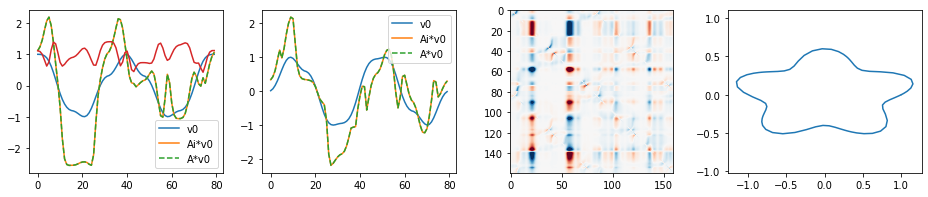

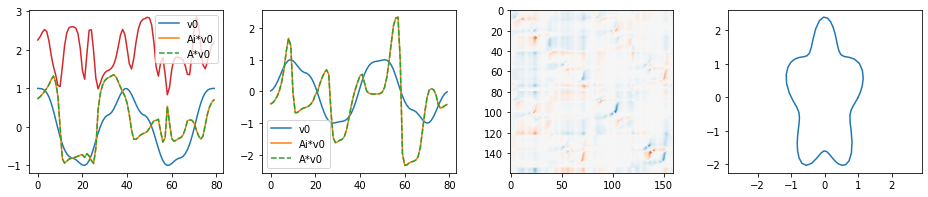

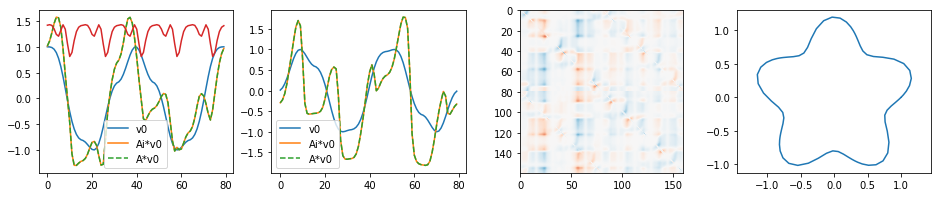

In [2]:
# Example of simple boundary
#N = 200
grid = GaussLegGrid(segments=np.linspace(0,2*np.pi,6), corners=None)
t, w = grid.get_grid_and_weights()
t = torch.from_numpy(t)
w = torch.from_numpy(w)
#dt = np.pi * 2 / N
#t  = torch.arange(0,N) * dt
#w = torch.ones(N,) * dt

# Ellipse
c = 0.2
f = 5
a = torch.Tensor([0.5, 2.0, 1.0])[:, None]
#z   =  torch.cos(t) + 1j * a * torch.sin(t) + c * torch.exp(f * t)
#dz  = -torch.sin(t) + 1j * a * torch.cos(t) + c * f * torch.exp(f * t)
#ddz = -torch.cos(t) - 1j * a * torch.sin(t) + c * f*f * torch.exp(f * t)

z   =  (torch.cos(t) + 1j * a * torch.sin(t))*(1 + c * torch.sin(f * t))
dz  =  (-torch.sin(t) + 1j * a * torch.cos(t))*(1 + c * torch.sin(f * t)) + \
        (torch.cos(t) + 1j * a * torch.sin(t))*(f * c * torch.cos(f * t))
ddz = (-torch.cos(t) - 1j * a * torch.sin(t))*(1 + c * torch.sin(f * t))+\
      2*(-torch.sin(t) + 1j * a * torch.cos(t))*(c * f * torch.cos(f * t))+\
      (torch.cos(t) + 1j * a * torch.sin(t))*(f*f*c*torch.sin(f*t))
a_vec = torch.zeros((3,))


# Stokes operator for boundary
A = StokesAdjointBoundaryOp(z, dz, ddz, w[None,:].repeat(z.shape[0],1), a_vec)

# Evaluate on v0
v0 = torch.exp(2j * t)[None, None, :]
v0_stack = torch.concat([torch.real(v0), torch.imag(v0)],axis=1).repeat(z.shape[0], 1, 1)
v = A(v0_stack)

# Separate x-y coords
x, y = torch.real(z), torch.imag(z)
dx, dy = torch.real(1j*dz), torch.imag(1j*dz)

K_mat_trch = []
for i in range(z.shape[0]):
    Ai = StokesAdjointBoundaryOp(z[i,:], dz[i,:], ddz[i,:], w, torch.tensor([a_vec[i]]))
    Aiv0 = Ai(v0_stack[None,i,:,:])
    
    Aiv0x, Aiv0y = Aiv0[0,0,:], Aiv0[0,1,:]
    Av0x, Av0y = v[i,0,:], v[i,1,:]
    v0x, v0y = torch.real(v0.squeeze()), torch.imag(v0.squeeze())

    # Plot x-values of velocities
    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1)
    plt.plot(v0x, label="v0")
    plt.plot(Aiv0x, label="Ai*v0")
    plt.plot(Av0x,'--', label="A*v0")
    plt.plot(np.abs(dz[i,:]))
    plt.plot()
    plt.legend()

    plt.subplot(1,4,2)
    plt.plot(v0y, label="v0")
    plt.plot(Aiv0y, label="Ai*v0")
    plt.plot(Av0y, '--', label="A*v0")
    plt.legend()
    
    plt.subplot(1,4,3)
    k = torch.vstack([torch.hstack([Ai.K[0,0,0,:,:], Ai.K[0,0,1,:,:]]),
                      torch.hstack([Ai.K[0,1,0,:,:], Ai.K[0,1,1,:,:]])])
    K_mat_trch.append(k.cpu() + np.eye(k.shape[0]))
    plt.imshow(k.cpu(), cmap="RdBu",vmin=-.5, vmax=.5)
    
    plt.subplot(1,4,4)
    plt.axis("equal")
    #remove_axes(plt.gca())
    plt.plot(x[i,:], y[i,:])
    
    

Next, compare with numpy code.

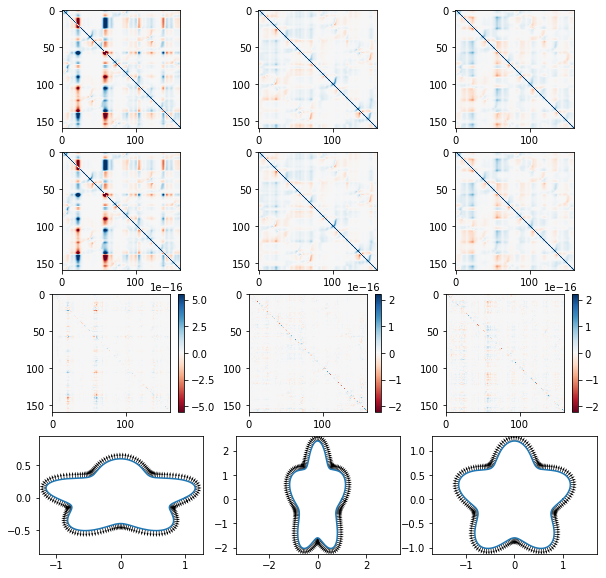

In [3]:
# Ellipse
grid = GaussLegGrid(segments=np.linspace(0,2*np.pi,6), corners=None)
t, w = grid.get_grid_and_weights()

c = 0.2
f = 5
a_ = [0.5, 2.0, 1.0]
#z   =  lambda t,a: np.cos(t) + 1j * a * np.sin(t) + c * np.exp(f * t)
#dz  =  lambda t,a: -np.sin(t) + 1j * a * np.cos(t) + c * f * np.exp(f * t)
#ddz =  lambda t,a: -np.cos(t) - 1j * a * np.sin(t) + c * f*f * np.exp(f * t)

z   =  lambda t,a: (np.cos(t) + 1j * a * np.sin(t))*(1. + c * np.sin(f * t))
dz  =  lambda t,a: (-np.sin(t) + 1j * a * np.cos(t))*(1. + c * np.sin(f * t)) + \
        (np.cos(t) + 1j * a * np.sin(t))*(f * c * np.cos(f * t))
ddz = lambda t,a: (-np.cos(t) - 1j * a * np.sin(t))*(1 + c * np.sin(f * t))+\
                  2*(-np.sin(t) + 1j * a * np.cos(t))*(c * f * np.cos(f * t))+\
                  (np.cos(t) + 1j * a * np.sin(t))*(f*f*c*np.sin(f*t))


geoms = []
K_mat = []
plt.figure(figsize=(10,10))
for i,a in enumerate(a_):
    param = [lambda t: z(t,a),\
             lambda t: dz(t,a),\
             lambda t: ddz(t,a)]
    geom = Geometry(param=param, grid=grid)
    geom.get_inner_pt = lambda: 0*1j
    geoms.append(geom)
    Kt = geom.stokes_adjoint_matrix()
    K_mat.append(Kt)
    
    plt.subplot(4,3,i+1)
    plt.imshow(Kt, cmap="RdBu",vmin=-.5, vmax=.5)
    
    plt.subplot(4,3,3+i+1)
    plt.imshow(K_mat_trch[i], cmap="RdBu",vmin=-.5, vmax=.5)
    
    plt.subplot(4,3,6+i+1)
    plt.imshow((K_mat_trch[i]-Kt), cmap="RdBu")
    plt.colorbar()
    
    plt.subplot(4,3,9+i+1)
    geom.plot(ax=plt.gca(), shownormals=True)
    #plt.plot(np.real(p), np.imag(p))
    plt.axis("equal")
    


## Explaining weird patterns.

The kernel matrices exhibit non-local behaviour, why is that? Let's investigate the kernel. For a circle with parametrisation

$ \gamma(t) = e^{it}, \qquad t \in [0, 2\pi]$

the operator can be described as 

$v(t) = \int_\gamma k(t,s)\rho(s)\mathrm{d}s + \int_\gamma \overline{k}(t,s)\overline{\rho}(s)\mathrm{d}s$

where

$k(t,s) = \mathrm{Im}\left\{\frac{\gamma'(t)}{\gamma(t)-\gamma(s)}\right\} = \mathrm{Im}\left\{\frac{ie^{it}}{e^{it}-e^{is}}\right\}=\frac{\mathrm{Im}\left\{ie^{it}(e^{-it}-e^{-is})\right\}}{(e^{it}-e^{is})(e^{-it}-e^{-is})}=\frac{\mathrm{Re}\left\{1-e^{i(t-s)}\right\}}{2-e^{i(t-s)}-e^{i(s-t)}}=\frac{1-cos(t-s)}{2(1-cos(t-s))}=\frac{1}{2}$

and

$\overline{k}(t,s) = \frac{\mathrm{Im}\left\{\gamma'(t)(\overline{\gamma}(t)-\overline{\gamma}(s))\right\}}{(\overline{\gamma}(t)-\overline{\gamma}(s))^2} = \frac{\mathrm{Im}\left\{ie^{it}(e^{-it}-e^{-is})\right\}}{(e^ {-it}-e^{-is})^2} = \frac{\mathrm{Re}\left\{1-e^{i(t-s)})\right\}}{e^ {-2it}-2e^{-i(t+s)}+e^{-2is}}=\frac{1-\cos(t-s)}{e^{-i(t+s)}(e^{i(s-t)}-2+e^{i(t-s)})}=-\frac{1}{2}e^{i(t+s)}$

Hence, the kernel operators of a circular domain exhibit non-local dependencies, which would limit the accuracy of a naive cnn design.

## Concistency against previous code

Load data generated using numpy solver routine. Applying the forward operator on the Y-data should make it match the X-data.

{'in_ch': ['zr', 'zi', 'dzr', 'dzi', 'ddzr', 'ddzi', 'line_eval_r', 'line_eval_i', 'w', 't'], 'out_ch': ['riesz_r', 'riesz_i']}


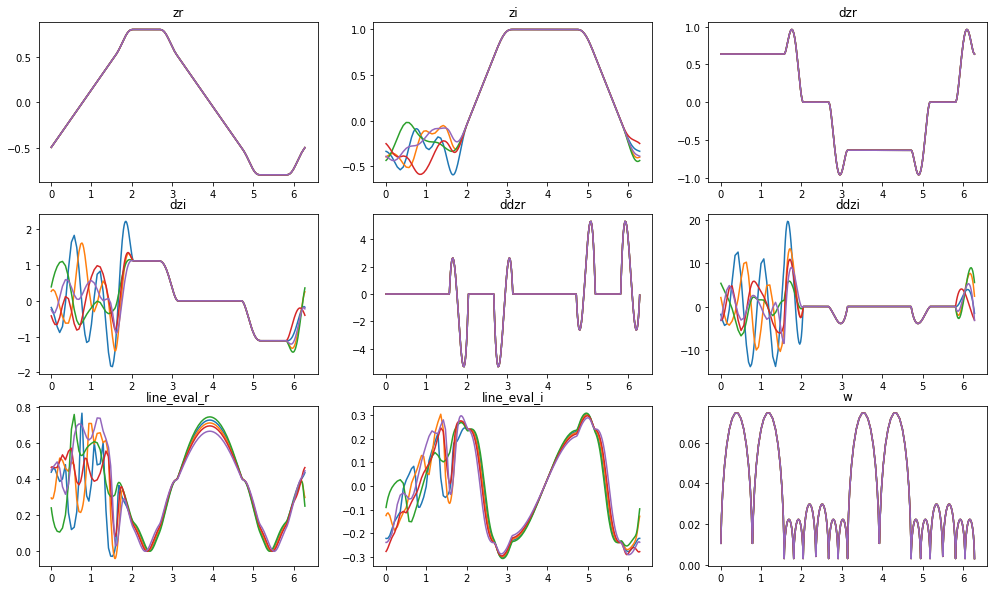

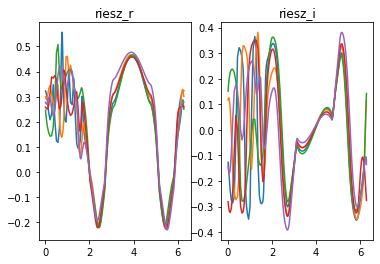

In [8]:
device = "cpu"#"cuda:1"
data = torch.load("/home/emastr/phd/data/problem_data_riesz_TEST.torch")
print(data['info'])

M = 20
X = data["X"].to(device)[0:M,:,:]
Y = data["Y"].to(device)[0:M,:,:]
in_ch = data["info"]["in_ch"]
out_ch = data["info"]["out_ch"]

n_X = round(np.sqrt(X.shape[1]))

plt.figure(figsize=(17,10))
for i in range(n_X * n_X):
    plt.subplot(n_X, n_X, i+1)
    if i < X.shape[1]:
        x1, x2 = X[0:5, 9, :].numpy().T, X[0:5, i, :].numpy().T
        plt.plot(x1, x2)
        plt.title(in_ch[i])
        

plt.figure()
for i in range(2):
    plt.subplot(1, 2, i+1)
    x1, x2 = X[0:5, 9, :].numpy().T, Y[0:5, i, :].numpy().T
    plt.plot(x1, x2)
    plt.title(out_ch[i])

In [5]:
# Define OPERATOR
N = X.shape[2]
Z   = X[:, 0, :] + 1j * X[:, 1, :]
dZ  = X[:, 2, :] + 1j * X[:, 3, :]
ddZ = X[:, 4, :] + 1j * X[:, 5, :]
V0  = X[:, 6:8, :]
W = X[:, 8, :]

a = torch.ones(M,) * 0.5 * 1j

# Define weights
#W = np.pi * 2 / N * torch.ones(Z.shape, device=device)
# dZ = (torch.roll(Z,0,dims=1) - torch.roll(Z,-1,dims=1))/W
# ddZ = (torch.roll(Z,1,dims=1) - 2*Z + torch.roll(Z,-1,dims=1))/W**2

op = StokesAdjointBoundaryOp(Z, dZ, ddZ, W, a)

(-0.8800000131130219,
 0.8800000131130219,
 -0.6743489861488342,
 1.0797309041023255)

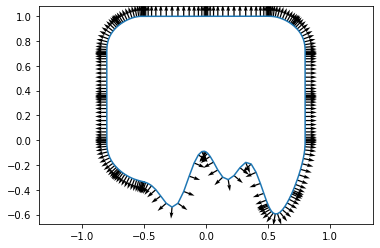

In [6]:
plt.plot(Z[0,:].real, Z[0,:].imag)
n = dZ[0,:] / torch.abs(dZ[0,:])
plt.quiver(Z[0,:].real, Z[0,:].imag, n.imag, -n.real)
plt.axis("equal")

Evaluate density with operator. Should obtain the boundary condition.

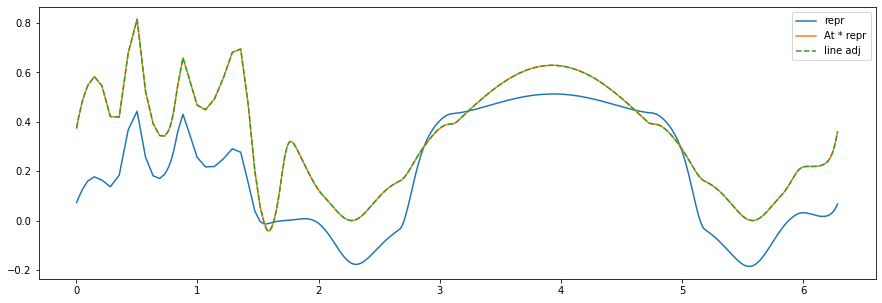

In [11]:
plt.figure(figsize=(15,5))

Ay = op(Y.to(torch.double))
idx = 19

x = X[idx, 9, :].numpy().T
y1 = Y[idx,0,:].numpy().T
y2 = Ay[idx,0,:].numpy().T
y3 = X[idx,6,:].numpy().T

plt.plot(x, y1, label="repr")
plt.plot(x, y2, label="At * repr")
plt.plot(x, y3, '--', label="line adj")
plt.legend()


# Compare to numpy implementation

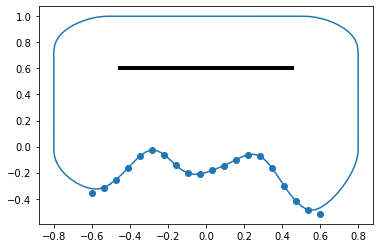

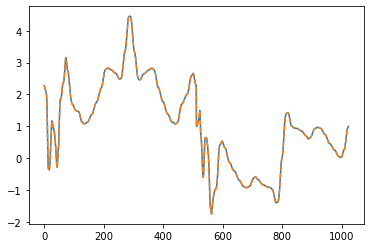

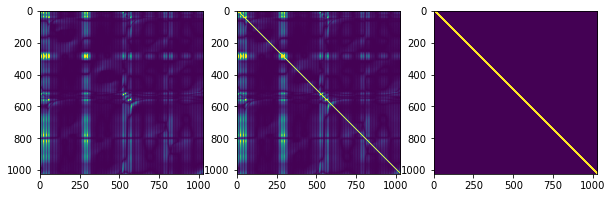

In [9]:
np.random.seed(0)
gpd = GPDomain("exp", 
                  shape=.05, 
                  num=20, 
                  scale=.05, 
                  bound=.3, 
                  width=1, 
                  height=1, 
                  corner_w = 0.3,
                  line_pos=0.6, 
                  n_refine=2, 
                  n_corner_refine=0)   


gpd.plot(ax=plt.gca())

t, w = gpd.grid.get_grid_and_weights()
z = gpd.eval_param(t=t, derivative=0).astype(np.complex128)
dz = gpd.eval_param(t=t, derivative=1).astype(np.complex128)
ddz = gpd.eval_param(t=t, derivative=2).astype(np.complex128)
v = np.ones_like(z)



Z = torch.from_numpy(z)[None, :]
dZ = torch.from_numpy(dz)[None, :]
ddZ = torch.from_numpy(ddz)[None, :]
V = torch.from_numpy(np.vstack([np.real(v), np.imag(v)]))[None,:]
W = w[None,:]
a = torch.tensor([gpd.get_inner_pt()])

gpdOp = StokesAdjointBoundaryOp(Z, dZ, ddZ, W, a)
w0 = gpdOp.forward(V).numpy().squeeze()
K0 = gpdOp.K

K1 = gpd.stokes_adjoint_matrix()
w1 = (K1 @ np.hstack([np.real(v), np.imag(v)]))


plt.figure()
plt.plot(np.hstack([w0[0,:],w0[1,:]]))
plt.plot(w1, '--')

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
K0 = K0.numpy().squeeze()
K0 = np.vstack([np.hstack([K0[0,0,:,:], K0[0,1,:,:]]),\
                np.hstack([K0[1,0,:,:], K0[1,1,:,:]])])
plt.imshow(np.abs(K0), vmin=0, vmax=.1)

plt.subplot(1,3,2)
plt.imshow(np.abs(K1), vmin=0, vmax=.1)

plt.subplot(1,3,3)
plt.imshow(np.abs(K1-K0), vmin=0, vmax=.01)

Try reconstruction with operator to see if we obtain the desired output.